<a href="https://colab.research.google.com/github/majjariswathi/Open-Source-Project/blob/master/Tennis_Match_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import sklearn.neighbors as neighbors
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [4]:
aus_men = pd.read_csv("AusOpen-men-2013.csv")
aus_women = pd.read_csv("AusOpen-women-2013.csv")
aus_men['slam_code'] = 1
aus_women['slam_code'] = 1
aus_women['Sex'] = 1
aus_men['Sex'] = 2


fre_men = pd.read_csv("FrenchOpen-men-2013.csv")
fre_women = pd.read_csv("FrenchOpen-women-2013.csv")
fre_men['slam_code'] = 2
fre_women['slam_code'] = 2
fre_women['Sex'] = 1
fre_men['Sex'] = 2

wim_men = pd.read_csv("Wimbledon-men-2013.csv")
wim_women = pd.read_csv("Wimbledon-women-2013.csv")
wim_men['slam_code'] = 3
wim_women['slam_code'] = 3
wim_women['Sex'] = 1
wim_men['Sex'] = 2

us_men = pd.read_csv("USOpen-men-2013.csv")
us_women = pd.read_csv("USOpen-women-2013.csv")
us_men['slam_code'] = 4
us_women['slam_code'] = 4
us_women['Sex'] = 1
us_men['Sex'] = 2

In [5]:
aus_men = aus_men.rename(columns={'FNL1': 'FNL.1', 'FNL2': 'FNL.2'})
aus_women = aus_women.rename(columns={'FNL1': 'FNL.1', 'FNL2': 'FNL.2'})

In [6]:
us_men = us_men.rename(columns={'FNL1': 'FNL.1', 'FNL2': 'FNL.2'})
us_women = us_women.rename(columns={'Player 1': 'Player1', 'Player 2': 'Player2'})

In [7]:
frames = [aus_men, fre_men, wim_men, us_men, aus_women, fre_women, wim_women, us_women]
tennis_merge = pd.concat(frames)

In [8]:
tennis_merge.columns[tennis_merge.isnull().any()]

Index(['FNL.1', 'FNL.2', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1', 'BPC.1', 'BPW.1',
       'NPA.1', 'NPW.1', 'TPW.1', 'ST1.1', 'ST2.1', 'ST3.1', 'ST4.1', 'ST5.1',
       'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'TPW.2', 'ST1.2', 'ST2.2', 'ST3.2', 'ST4.2', 'ST5.2'],
      dtype='object')

In [9]:
tennis_merge.head()

,Player1,Player2,Round,Result,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2,slam_code,Sex
0,Lukas Lacko,Novak Djokovic,1,0,0.0,3.0,61,35,39,18,5.0,1.0,17.0,29.0,1.0,3.0,8.0,11.0,70.0,3.0,6.0,1.0,NaN,NaN,68,45,32,17,10.0,0.0,40.0,30.0,4.0,8.0,8.0,9.0,101.0,6.0,7.0,6.0,NaN,NaN,1,2
1,Leonardo Mayer,Albert Montanes,1,1,3.0,0.0,61,31,39,13,13.0,1.0,13.0,1.0,7.0,14.0,NaN,NaN,80.0,6.0,6.0,6.0,NaN,NaN,60,23,40,9,1.0,4.0,1.0,4.0,0.0,0.0,NaN,NaN,42.0,1.0,3.0,1.0,NaN,NaN,1,2
2,Marcos Baghdatis,Denis Istomin,1,0,0.0,3.0,52,53,48,20,8.0,4.0,37.0,50.0,1.0,9.0,16.0,23.0,106.0,4.0,5.0,4.0,NaN,NaN,77,57,23,15,9.0,1.0,41.0,41.0,4.0,13.0,12.0,16.0,126.0,6.0,7.0,6.0,NaN,NaN,1,2
3,Dmitry Tursunov,Michael Russell,1,1,3.0,0.0,53,39,47,24,8.0,6.0,8.0,6.0,6.0,9.0,NaN,NaN,104.0,6.0,6.0,6.0,NaN,NaN,50,24,50,19,1.0,8.0,1.0,8.0,1.0,7.0,NaN,NaN,79.0,2.0,2.0,3.0,NaN,NaN,1,2
4,Juan Monaco,Ernests Gulbis,1,0,1.0,3.0,76,63,24,12,0.0,4.0,16.0,35.0,3.0,12.0,9.0,13.0,128.0,6.0,4.0,6.0,2.0,NaN,53,59,47,32,17.0,11.0,59.0,79.0,3.0,5.0,16.0,28.0,127.0,1.0,6.0,7.0,6.0,NaN,1,2


In [11]:
tennis_merge = tennis_merge.reindex(
    columns = (['Player1','Player2'] + 
               list([a for a in tennis_merge.columns if a not in ('Player1','Player2')]
                   ) 
              )
)

In [14]:
tennis_merge[(tennis_merge['ST3.1'].isnull()) & (tennis_merge['Sex'] == 2)]

,Player1,Player2,Round,Result,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2,slam_code,Sex
7,Fabio Fognini,Alex Bogomolov Jr.,1,1,2.0,0.0,47,18,53,15,3.0,4.0,21.0,31.0,6.0,20.0,6.0,9.0,78.0,6.0,6.0,NaN,NaN,NaN,54,26,46,13,0.0,11.0,11.0,46.0,2.0,6.0,8.0,12.0,61.0,3.0,2.0,NaN,NaN,NaN,1,2
15,Stanislas Wawrinka,Andrey Golubev,1,1,2.0,0.0,63,20,37,6,4.0,1.0,23.0,11.0,4.0,9.0,13.0,14.0,54.0,6.0,4.0,NaN,NaN,NaN,64,18,36,10,0.0,0.0,8.0,15.0,1.0,2.0,6.0,12.0,37.0,4.0,1.0,NaN,NaN,NaN,1,2
24,Guillermo Garcia-Lopez,Tommy Haas,1,1,2.0,0.0,58,27,42,11,7.0,3.0,19.0,9.0,4.0,4.0,3.0,5.0,65.0,7.0,5.0,NaN,NaN,NaN,52,22,48,11,4.0,7.0,18.0,35.0,1.0,2.0,10.0,10.0,55.0,5.0,2.0,NaN,NaN,NaN,1,2
40,Martin Klizan,John Isner,1,1,2.0,0.0,54,25,46,21,9.0,2.0,27.0,10.0,2.0,5.0,1.0,3.0,71.0,6.0,7.0,NaN,NaN,NaN,78,36,22,6,10.0,0.0,23.0,23.0,0.0,3.0,5.0,10.0,52.0,2.0,6.0,NaN,NaN,NaN,1,2
63,Rafael Nadal,Bernard Tomic,1,1,1.0,0.0,62,14,38,6,5.0,1.0,13.0,5.0,1.0,1.0,5.0,5.0,30.0,6.0,NaN,NaN,NaN,NaN,71,15,29,3,3.0,1.0,13.0,7.0,0.0,0.0,3.0,5.0,24.0,4.0,NaN,NaN,NaN,NaN,1,2
59,Alejandro Falla,Grigor Dimitrov,1,0,0.0,2.0,54,10,46,7,1.0,1.0,6.0,15.0,1.0,5.0,5.0,7.0,38.0,4.0,0.0,NaN,NaN,NaN,59,20,41,10,2.0,1.0,14.0,16.0,2.0,2.0,6.0,7.0,48.0,6.0,1.0,NaN,NaN,NaN,2,2
91,Dmitry Tursunov,Victor Hanescu,2,0,0.0,2.0,59,31,41,9,6.0,4.0,25.0,15.0,2.0,2.0,6.0,9.0,62.0,4.0,6.0,NaN,NaN,NaN,67,33,33,9,6.0,0.0,24.0,10.0,3.0,5.0,5.0,6.0,66.0,6.0,6.0,NaN,NaN,NaN,2,2
65,Guillaume Rufin,Dmitry Tursunov,1,0,0.0,2.0,43,14,57,12,4.0,1.0,NaN,NaN,1.0,8.0,NaN,NaN,48.0,6.0,1.0,NaN,NaN,NaN,58,24,42,13,3.0,3.0,NaN,NaN,1.0,2.0,NaN,NaN,51.0,7.0,1.0,NaN,NaN,NaN,4,2


In [15]:
#Abandoned games women
tennis_merge[(tennis_merge['ST2.1'].isnull()) & (tennis_merge['Sex'] == 1)]

,Player1,Player2,Round,Result,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2,slam_code,Sex
44,Alize Cornet,Polona Hercog,1,0,NaN,NaN,75,3,25,1,1.0,NaN,2.0,0.0,NaN,NaN,1.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,0,0,100,1,0.0,NaN,1.0,1.0,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1,1
76,Ashleigh Barty,Maria Kirilenko,2,0,0.0,1.0,61,6,39,4,0.0,NaN,9.0,5.0,1.0,1.0,2.0,2.0,16.0,3.0,NaN,NaN,NaN,NaN,75,9,25,1,1.0,NaN,7.0,4.0,1.0,1.0,5.0,6.0,18.0,3.0,NaN,NaN,NaN,NaN,2,1
77,Kaia Kanepi,Stefanie Voegele,2,1,1.0,0.0,71,20,29,5,4.0,2.0,16.0,15.0,1.0,3.0,0.0,4.0,41.0,6.0,NaN,NaN,NaN,NaN,58,13,42,9,0.0,1.0,15.0,9.0,1.0,6.0,4.0,6.0,39.0,5.0,NaN,NaN,NaN,NaN,2,1


In [16]:
## Removing abandoned games
tennis_merge = tennis_merge[-((tennis_merge['ST3.1'].isnull()) & (tennis_merge['Sex'] == 2))] #For men

tennis_merge = tennis_merge[-((tennis_merge['ST2.1'].isnull()) & (tennis_merge['Sex'] == 1))] #For women

In [17]:
## Feature engineering1: Find difference between games won in sets as this would indicate who won the set
# If positive: Player 1 wins the set Else Player 2
# The value is NaN if the set did not occur, in which case we set it to 0(0 can never occur otherwise)
tennis_merge['ST1'] = tennis_merge['ST1.1'] - tennis_merge['ST1.2']
tennis_merge['ST2'] = tennis_merge['ST2.1'] - tennis_merge['ST2.2']
tennis_merge['ST3'] = tennis_merge['ST3.1'] - tennis_merge['ST3.2']
tennis_merge['ST4'] = tennis_merge['ST4.1'] - tennis_merge['ST4.2']
tennis_merge['ST5'] = tennis_merge['ST5.1'] - tennis_merge['ST5.2']

In [18]:
## Replace NaN with 0s
tennis_merge['ST3'].fillna(0, inplace=True)
tennis_merge['ST4'].fillna(0, inplace=True)
tennis_merge['ST5'].fillna(0, inplace=True)

In [19]:
tennis_merge.columns

Index(['Player1', 'Player2', 'Round', 'Result', 'FNL.1', 'FNL.2', 'FSP.1',
       'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1', 'BPC.1',
       'BPW.1', 'NPA.1', 'NPW.1', 'TPW.1', 'ST1.1', 'ST2.1', 'ST3.1', 'ST4.1',
       'ST5.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2', 'ACE.2', 'DBF.2', 'WNR.2',
       'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2', 'TPW.2', 'ST1.2', 'ST2.2',
       'ST3.2', 'ST4.2', 'ST5.2', 'slam_code', 'Sex', 'ST1', 'ST2', 'ST3',
       'ST4', 'ST5'],
      dtype='object')

In [20]:
#removing names of players as we aren't considering ranking here
# removing set info cause we have created another column
# removing Total points won cause there are too many missing values
rem_cols = ['Player1','Player2','TPW.1','TPW.2','FNL.1','FNL.2',
            'ST1.1','ST2.1','ST3.1','ST4.1','ST5.1',
            'ST1.2','ST2.2','ST3.2','ST4.2','ST5.2','ST1','ST2','ST3','ST4','ST5']

tennis_feat = tennis_merge.drop(rem_cols,axis  = 1,inplace = False) #removes columns

tennis_feat = shuffle(tennis_feat) #shuffles

#convert numeric to categorical
col_names = ['Round','slam_code','Sex','Result']
for col in col_names:
    tennis_feat[col] = tennis_feat[col].astype('category',copy=False)
    
#Train-test split. 30% for test
train,test = train_test_split(tennis_feat,test_size = 0.3)

In [21]:
tennis_feat[tennis_feat.columns[:]].isnull().sum().sort_values()

Round          0
BPW.2          0
BPC.2          0
SSW.2          0
SSP.2          0
FSW.2          0
FSP.2          0
slam_code      0
BPW.1          0
BPC.1          0
Sex            0
SSW.1          0
SSP.1          0
FSW.1          0
Result         0
FSP.1          0
DBF.2          6
DBF.1          6
ACE.1         22
ACE.2         22
NPW.2         82
NPW.1         82
NPA.2         83
NPA.1         83
WNR.2        125
UFE.1        125
UFE.2        125
WNR.1        125
dtype: int64

In [22]:

#convert numeric to categorical
col_names = ['Round','slam_code','Sex','Result']
for col in col_names:
    tennis_feat[col] = tennis_feat[col].astype('category',copy=False)

In [23]:
### Imputing mean values for men and women separately
## for columns - ACES, Net point won, Net points attempted, Winners hit and Unforced errors
## This is because this usually fluctates around the mean value for men's and women's tennis
print("Median for Winners player 1(MEN)",tennis_feat[tennis_feat["Sex"] == 2]["WNR.1"].median())
print("Median for Winners player 2(MEN)",tennis_feat[tennis_feat["Sex"] == 2]["WNR.2"].median())

print("Median for Ace player 1(WOMEN)",tennis_feat[tennis_feat["Sex"] == 1]["ACE.1"].median())
print("Median for Ace player 2(WOMEN)",tennis_feat[tennis_feat["Sex"] == 1]["ACE.2"].median())

print("Median for Net points attempted 1(WOMEN)",tennis_feat[tennis_feat["Sex"] == 1]["NPA.1"].median())
print("Median for Net points attempted 2(WOMEN)",tennis_feat[tennis_feat["Sex"] == 1]["NPA.2"].median())

print("Median for Net points attempted 1(MEN)",tennis_feat[tennis_feat["Sex"] == 2]["NPA.1"].median())
print("Median for Net points attempted 2(MEN)",tennis_feat[tennis_feat["Sex"] == 2]["NPA.2"].median())

print("Median for Net points won 1(WOMEN)",tennis_feat[tennis_feat["Sex"] == 1]["NPW.1"].median())
print("Median for Net points won 2(WOMEN)",tennis_feat[tennis_feat["Sex"] == 1]["NPW.2"].median())

print("Median for Net points Won 1(MEN)",tennis_feat[tennis_feat["Sex"] == 2]["NPW.1"].median())
print("Median for Net points Won 2(MEN)",tennis_feat[tennis_feat["Sex"] == 2]["NPW.2"].median())

Median for Winners player 1(MEN) 35.0
Median for Winners player 2(MEN) 36.0
Median for Ace player 1(WOMEN) 2.0
Median for Ace player 2(WOMEN) 2.0
Median for Net points attempted 1(WOMEN) 9.0
Median for Net points attempted 2(WOMEN) 9.0
Median for Net points attempted 1(MEN) 17.0
Median for Net points attempted 2(MEN) 18.0
Median for Net points won 1(WOMEN) 9.5
Median for Net points won 2(WOMEN) 9.0
Median for Net points Won 1(MEN) 22.0
Median for Net points Won 2(MEN) 22.0


In [24]:
#src: https://stackoverflow.com/a/21463854
tennis_feat["NPW.1"] = tennis_feat["NPW.1"].fillna(round(tennis_feat.groupby("Sex")["NPW.1"].transform("median"),2))
tennis_feat["NPW.2"] = tennis_feat["NPW.2"].fillna(round(tennis_feat.groupby("Sex")["NPW.2"].transform("median"),2))

tennis_feat["NPA.1"] = tennis_feat["NPA.1"].fillna(tennis_feat.groupby("Sex")["NPA.1"].transform("median"))
tennis_feat["NPA.2"] = tennis_feat["NPA.2"].fillna(tennis_feat.groupby("Sex")["NPA.2"].transform("median"))

tennis_feat["ACE.1"] = tennis_feat["ACE.1"].fillna(tennis_feat.groupby("Sex")["ACE.1"].transform("median"))
tennis_feat["ACE.2"] = tennis_feat["ACE.2"].fillna(tennis_feat.groupby("Sex")["ACE.2"].transform("median"))

tennis_feat["WNR.1"] = tennis_feat["WNR.1"].fillna(tennis_feat.groupby("Sex")["WNR.1"].transform("median"))
tennis_feat["WNR.2"] = tennis_feat["WNR.2"].fillna(tennis_feat.groupby("Sex")["WNR.2"].transform("median"))

tennis_feat["DBF.1"] = tennis_feat["DBF.1"].fillna(tennis_feat.groupby("Sex")["DBF.1"].transform("median"))
tennis_feat["DBF.2"] = tennis_feat["DBF.2"].fillna(tennis_feat.groupby("Sex")["DBF.2"].transform("median"))

tennis_feat["UFE.1"] = tennis_feat["UFE.1"].fillna(tennis_feat.groupby("Sex")["UFE.1"].transform("median"))
tennis_feat["UFE.2"] = tennis_feat["UFE.2"].fillna(tennis_feat.groupby("Sex")["UFE.2"].transform("median"))

In [25]:
tennis_feat[tennis_feat.columns[:]].isnull().sum().sort_values()


Round        0
NPW.2        0
NPA.2        0
BPW.2        0
BPC.2        0
UFE.2        0
WNR.2        0
DBF.2        0
ACE.2        0
SSW.2        0
SSP.2        0
FSW.2        0
FSP.2        0
NPW.1        0
NPA.1        0
BPW.1        0
BPC.1        0
UFE.1        0
WNR.1        0
DBF.1        0
ACE.1        0
SSW.1        0
SSP.1        0
FSW.1        0
FSP.1        0
Result       0
slam_code    0
Sex          0
dtype: int64

In [26]:
tennis_feat.select_dtypes(include=[np.number]).columns


Index(['FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2',
       'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2'],
      dtype='object')

In [27]:
tennis_feat.to_csv('Cleansed_data.csv')

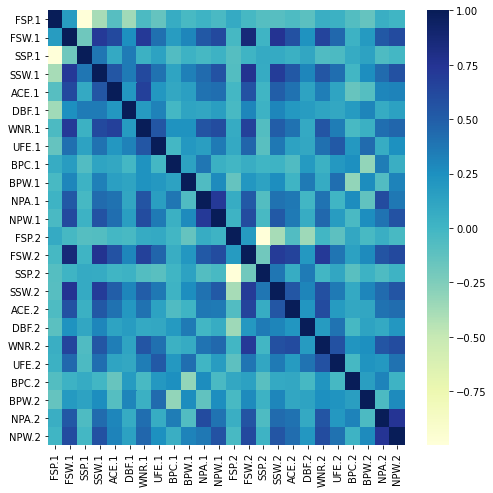

In [28]:
plt.figure(figsize=(8,8))
sns_heat = sns.heatmap(tennis_feat.corr(),cmap="YlGnBu")
plt.savefig("Heatplot.png")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


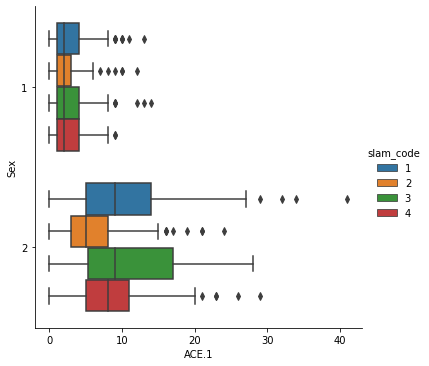

In [29]:
Aces_slam = sns.factorplot(x="ACE.1", y="Sex", hue="slam_code", data=tennis_feat, kind="box")
plt.savefig("Aces.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


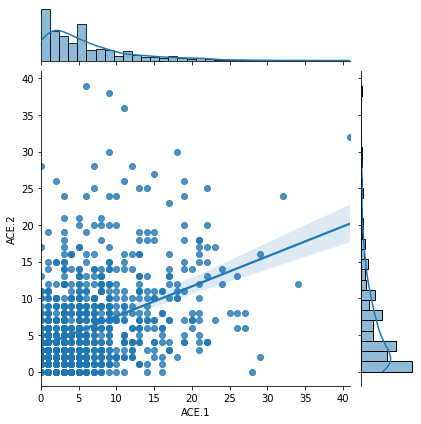

In [30]:
Aces_dist = sns.jointplot("ACE.1", "ACE.2", tennis_feat, kind="reg")
plt.savefig("Aces_dist.png")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


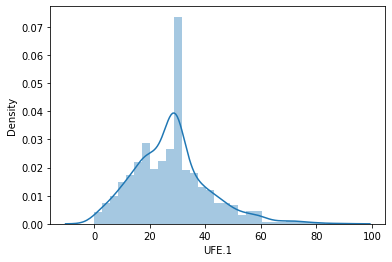

In [31]:
sns.distplot(tennis_feat['UFE.1'])
plt.savefig("/Unforced.png")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


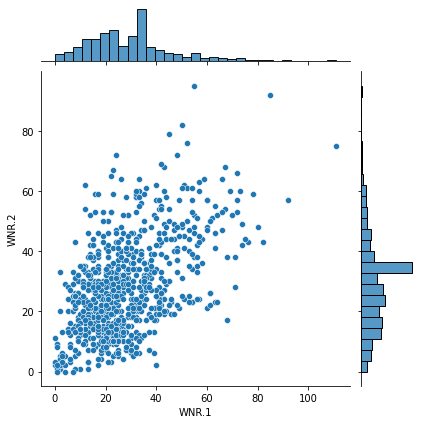

In [32]:
sns.jointplot(tennis_feat['WNR.1'],tennis_feat['WNR.2'])
plt.savefig("Winners_comp.png")

In [33]:
df_desc = tennis_feat.select_dtypes(include = [np.number]).describe()

In [34]:
df_desc.to_csv('Numeric_desription.csv')

In [44]:
#Feature scaling
def scale_matrix(matrix,num_feat,non_num_feat):
    scl = StandardScaler()
    scl_mat = scl.fit_transform(matrix[num_feat])
    temp = np.concatenate((scl_mat,
                    matrix[non_num_feat].to_numpy().astype('int')),
                   axis = 1)
#     temp = temp.astype(int)
    return temp

In [36]:
#numeric columns
numeric_features = tennis_feat.select_dtypes(include=[np.number]).columns

#non-numeric columns
non_num_features = tennis_feat.select_dtypes(exclude=[np.number]).columns

In [37]:
Features = list(numeric_features)+(list(non_num_features))

In [38]:
print(Features)

['FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1', 'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2', 'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2', 'Round', 'Result', 'slam_code', 'Sex']


In [45]:
import pandas as pd
tennis_scaled = pd.DataFrame(scale_matrix(tennis_feat,numeric_features,non_num_features))


In [47]:
tennis_scaled.columns = Features

In [49]:
col_names = ['Round','slam_code','Sex','Result']
for col in col_names:
    tennis_scaled[col] = tennis_scaled[col].astype('category',copy=False)

In [50]:
tennis_dummy = pd.get_dummies(tennis_scaled)

In [51]:
tennis_dummy.columns

Index(['FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2',
       'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'Round_1.0', 'Round_2.0', 'Round_3.0', 'Round_4.0', 'Round_5.0',
       'Round_6.0', 'Round_7.0', 'Result_0.0', 'Result_1.0', 'slam_code_1.0',
       'slam_code_2.0', 'slam_code_3.0', 'slam_code_4.0', 'Sex_1.0',
       'Sex_2.0'],
      dtype='object')

In [52]:
tennis_dummy['Result_0.0'].sum()

473

In [53]:
rem_cols_dummy = ['Result_0.0','Sex_2.0','slam_code_1.0','slam_code_2.0',
                  'slam_code_3.0','slam_code_4.0']

tennis_final = tennis_dummy.drop(rem_cols_dummy,axis  = 1,inplace = False)

In [54]:
tennis_final.columns

Index(['FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2',
       'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'Round_1.0', 'Round_2.0', 'Round_3.0', 'Round_4.0', 'Round_5.0',
       'Round_6.0', 'Round_7.0', 'Result_1.0', 'Sex_1.0'],
      dtype='object')

In [56]:
#Train-test split. 30% for test
train_valid,test = train_test_split(tennis_final,test_size = 0.3,random_state=12345)
train,valid = train_test_split(train_valid,test_size = 0.3,random_state=12345)

In [57]:
Xtrain = train.iloc[:, train.columns != "Result_1.0"]
ytrain = train.iloc[:, train.columns == "Result_1.0"]

Xvalid = valid.iloc[:, valid.columns != "Result_1.0"]
yvalid = valid.iloc[:, valid.columns == "Result_1.0"]

Xtest = test.iloc[:, test.columns != "Result_1.0"]
ytest = test.iloc[:, test.columns == "Result_1.0"]

In [58]:
Xtrain.columns

Index(['FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2',
       'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'Round_1.0', 'Round_2.0', 'Round_3.0', 'Round_4.0', 'Round_5.0',
       'Round_6.0', 'Round_7.0', 'Sex_1.0'],
      dtype='object')

In [63]:
Xtrain = Xtrain.to_numpy()
Xvalid = Xvalid.to_numpy()
Xtest = Xtest.to_numpy()
ytrain = np.ravel(ytrain.to_numpy())
yvalid = np.ravel(yvalid.to_numpy())
ytest = np.ravel(ytest.to_numpy())

In [64]:
XCross = np.concatenate((Xtrain,Xvalid))
yCross = np.concatenate((ytrain,yvalid))

## ***KNN***


In [66]:
import sklearn.neighbors as neighbors
knn=neighbors.KNeighborsClassifier()

In [67]:
from sklearn.neighbors import KNeighborsClassifier
k = KNeighborsClassifier(n_neighbors = 3)
k.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [68]:
y_pred = k.predict(Xtest)

In [69]:
(y_pred != ytest).sum()

47

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_pred)

0.8321428571428572

In [71]:
t=[]
n=11
for i in range(1,n):
    classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    classifier.fit(Xtrain, ytrain)
    y_pred = classifier.predict(Xtest)
    cm = accuracy_score(ytest, y_pred)
    t.append(cm)
    print("Value of k=",i)
    print(cm)


#Printing maximum k value between 1 to 10
a=t.index(max(t))
a+=1
print("Maximum accuracy at k = ",a)
print(max(t))

Value of k= 1
0.8321428571428572
Value of k= 2
0.7964285714285714
Value of k= 3
0.8321428571428572
Value of k= 4
0.825
Value of k= 5
0.8535714285714285
Value of k= 6
0.8607142857142858
Value of k= 7
0.8678571428571429
Value of k= 8
0.875
Value of k= 9
0.8535714285714285
Value of k= 10
0.875
Maximum accuracy at k =  8
0.875


In [72]:
rnf = RandomForestClassifier()
rnf.fit(Xtrain, ytrain)
print("Train score",rnf.score(Xtrain,ytrain))
print("Validation score",rnf.score(Xvalid,yvalid))
print("Test score",rnf.score(Xtest,ytest))

Train score 1.0
Validation score 0.8928571428571429
Test score 0.9142857142857143


In [74]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(penalty = 'l2',C=1)
lg.fit(Xtrain,ytrain)

print("Num Features: %d",lg.coef_)
print("Selected Features: %s",lg.intercept_)
print('Actual number of iterations for all classes: ', lg.n_iter_)

# Compute the training accuracy
print('Mean accuracy  of training data: {0:.2f}%'
      .format(100 * lg.score(Xtrain, ytrain)))
# # Compute the validation accuracy
print('Mean accuracy  of validation data: {0:.2f}'
      .format(100 * lg.score(Xvalid, yvalid)))
# # # Compute the test accuracy
print('Mean accuracy  of test data: {0:.2f}'
      .format(100 * lg.score(Xtest, ytest)))

Num Features: %d [[ 0.17637104  2.05328519 -0.17290415  1.09679538  0.16929293 -0.11833352
   1.29749571 -0.65149756  1.49188624  1.49249881  0.4488693  -0.78476459
  -0.24292582 -2.20189449  0.24154199 -1.29639873 -0.460085    0.08803006
  -0.48627234  0.60815216 -1.61635994 -0.8703911  -0.35790352  0.4912514
  -0.03743947  0.25947773  0.16603979 -0.37960947 -0.03350581  0.01003518
   0.01436406  0.31006272]]
Selected Features: %s [-0.36603653]
Actual number of iterations for all classes:  [44]
Mean accuracy  of training data: 96.05%
Mean accuracy  of validation data: 90.31
Mean accuracy  of test data: 92.14
